In [ ]:
!pip -V

In [4]:
# import cv2
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def kmeans_color_quantization(image, k=3):
    # Преобразование изображения в формат, подходящий для KMeans
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Параметры для KMeans
    # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Применение KMeans
    labels = kmeans.fit_predict(pixel_values)
    centers = kmeans.cluster_centers_

    # Преобразование центров обратно в uint8
    centers = np.uint8(centers)

    # Назначение каждого пикселя изображения цветом соответствующего кластера
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image




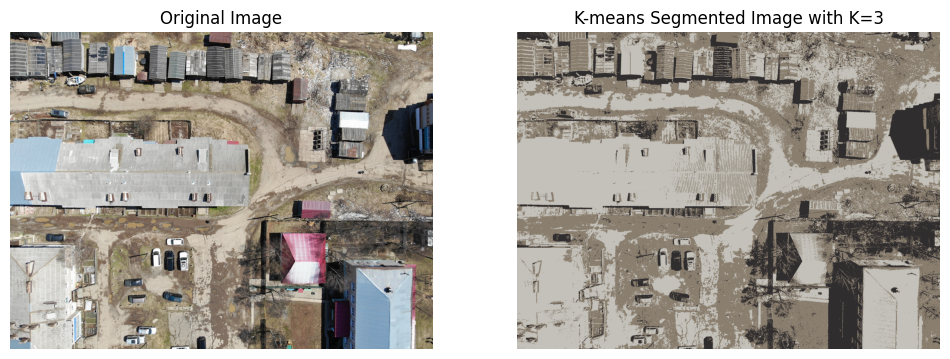

In [5]:
# Загрузка изображения
# image = cv2.imread('path_to_your_image.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование в RGB
image = Image.open('../assets/DJI_1065.png').convert('RGB')


# Применение K-means кластеризации
k = 3  # Количество кластеров
segmented_image = kmeans_color_quantization(np.array(image), k)

# Отображение результата
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title(f'K-means Segmented Image with K={k}')
plt.axis('off')

plt.show()

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import os


def kmeans_color_quantization(pixel_values, k=3):
    # Параметры для KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Применение KMeans
    kmeans.fit(pixel_values)

    # Преобразование центров обратно в uint8
    centers = np.uint8(kmeans.cluster_centers_)

    return kmeans, centers


# Путь к папке с изображениями
image_folder = 'path_to_your_image_folder'
output_folder = 'path_to_output_folder'

# Создание выходной папки, если она не существует
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Количество кластеров
k = 3

# Список для хранения всех пикселей
all_pixel_values = []

# Обработка каждого изображения в папке
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Загрузка изображения
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')

        # Преобразование изображения в формат, подходящий для KMeans
        pixel_values = np.array(image).reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Добавление пикселей в общий список
        all_pixel_values.append(pixel_values)

# Объединение всех пикселей в один большой набор данных
all_pixel_values = np.vstack(all_pixel_values)

# Применение K-means кластеризации ко всему набору данных
kmeans, centers = kmeans_color_quantization(all_pixel_values, k)

# Обработка каждого изображения в папке с использованием полученных центров кластеров
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Загрузка изображения
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')

        # Преобразование изображения в формат, подходящий для KMeans
        pixel_values = np.array(image).reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Назначение каждого пикселя изображения цветом соответствующего кластера
        labels = kmeans.predict(pixel_values)
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(image.shape)

        # Сохранение сегментированного изображения
        output_path = os.path.join(output_folder, filename)
        segmented_image = Image.fromarray(segmented_image.astype('uint8'))
        segmented_image.save(output_path)

        print(f'Processed and saved: {output_path}')

print('All images processed and saved.')